In [ ]:
import lightkurve as lk

def download_all_sectors(tic_id, author="SPOC"):
    search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author=author)
    data = {}
    
    for row in search:
        # 有些 LightKurve 版本可以直接 row.sector；保险一点：
        mission_str = row.table["mission"][0]
        # "TESS Sector 92" -> 92
        sector_num = int(str(mission_str).split()[-1])

        print(f"Downloading TIC {tic_id} Sector {sector_num} ...")
        lc = (row
              .download(flux_column="pdcsap_flux")
              .remove_nans()
              .normalize())

        data[sector_num] = lc

    return data

tic_id = 29857954
sector_data = download_all_sectors(tic_id)
print(sector_data.keys())
# 举例：访问 Sector 92
lc92 = sector_data[92]


dict_keys([28, 68, 92, 95])


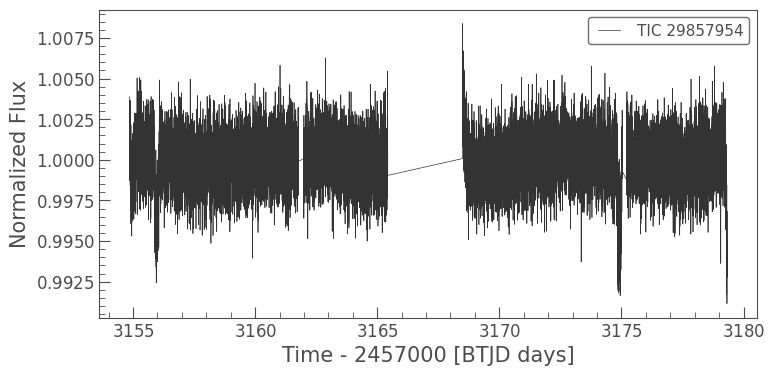

In [26]:
import matplotlib.pyplot as plt
lc68 = sector_data[68]
lc68.plot()
plt.show()

In [27]:
import numpy as np
print(np.mean(np.isnan(lc68.flux)))

0.0


In [1]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

import arviz as az
import corner

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")          # 有 GPU 想用的话改成 "gpu"
numpyro.set_host_device_count(2)     # 两个链并行


# ============================================
# 1. 从你的 dict 中取一个 sector 的 LightCurve
# ============================================
# 假设你已经有 sector_data 这个 dict，
# 比如之前是：sector_data = download_all_sectors(tic_id)
# 这里我们就选 Sector 92 来拟合：

# 如果你的 key 是 92：
# lc = sector_data[92]

# 如果你的 key 是 (92, 158) 这种 (sector, exptime)：
# lc = sector_data[(92, 158)]

# 请根据你自己的 dict 改这一行 👇
lc = sector_data[92]   # TODO：如果你用的是 (92, 158)，就改成 sector_data[(92, 158)]

# 提取时间、flux、误差（全部用 numpy array）
time_np = lc.time.value          # BTJD, 单位：day
flux_np = lc.flux.value          # 已经 normalize 的光通量

if lc.flux_err is not None:
    flux_err_np = lc.flux_err.value
else:
    # 如果没有误差，就先用全局 std 粗略估计一个常数噪声
    flux_err_np = np.full_like(flux_np, np.std(flux_np))

# 转成 JAX array
time = jnp.array(time_np)
flux = jnp.array(flux_np)
flux_err = jnp.array(flux_err_np)


# ============================================
# 2. 给一个初始参数猜测（相当于你的“先验中心”）
#    这部分有点像你给的 PyMC 代码里 Uniform/Normal 那些先验
# ============================================
# 你需要自己给出这个行星的大概：
#   - PERIOD_INIT：轨道周期 [day]
#   - DURATION_INIT：凌日持续时间 [day]
#   - T0_INIT：某次凌日的参考时间 [BTJD]
# 可以先大概给一个，后面不满意再调。

# ======= 这三个一定要改成你自己的值！=======
PERIOD_INIT   = 9.7                 # TODO：这个行星的大概周期（天）
DURATION_INIT = 0.2                 # TODO：大概凌日持续时间（天）
T0_INIT       = float(time_np.mean())  # TODO：某次凌日中心，先用本 sector 中点占位
# ===========================================


# ============================================
# 3. jaxoplanet 的光变模型
#    （结构类似你 PyMC 里把参数塞进 RUWE() 那样）
# ============================================
def light_curve_model(t, params):
    """
    使用 jaxoplanet 计算 limb-darkened transit light curve.
    params: dict, 包含
        - period
        - duration
        - t0
        - b
        - r
        - u: array([u1, u2])
    """
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        time_transit=params["t0"],
        impact_param=params["b"],
        radius_ratio=params["r"],
    )
    return limb_dark_light_curve(orbit, params["u"])(t)


# ============================================
# 4. NumPyro 模型（对应你 PyMC 里的 build_model）
#    priors 的风格跟你给的 PyMC 类似：Uniform / Normal / log-space 等
# ============================================
def transit_model(t, yerr, y=None):
    # t0：以 T0_INIT 为中心，1 天的 Normal 先验
    t0 = numpyro.sample("t0", dist.Normal(T0_INIT, 1.0))

    # period：在 log 空间采样，正类似你 PyMC 里 log_a / log_m2 的写法
    logP = numpyro.sample("logP", dist.Normal(jnp.log(PERIOD_INIT), 0.2))
    period = numpyro.deterministic("period", jnp.exp(logP))

    # duration：同样 log 空间
    logD = numpyro.sample("logD", dist.Normal(jnp.log(DURATION_INIT), 0.3))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # 半径比 r：类似你用 Uniform 对 log_a 做边界，这里直接 Uniform 在[0.01, 0.3]
    r = numpyro.sample("r", dist.Uniform(0.01, 0.3))

    # impact parameter b：通过 _b Uniform(0,1) 再缩放到 [0, 1+r]
    _b = numpyro.sample("_b", dist.Uniform(0.0, 1.0))
    b = numpyro.deterministic("b", _b * (1.0 + r))

    # limb darkening：用两个 Normal 先验，类似给 ruwe sigma0 HalfNormal 的那种软约束
    u1 = numpyro.sample("u1", dist.Normal(0.3, 0.3))
    u2 = numpyro.sample("u2", dist.Normal(0.2, 0.3))
    u = jnp.array([u1, u2])

    # 用 jaxoplanet 算光变
    y_model = light_curve_model(
        t,
        {"period": period, "duration": duration, "t0": t0, "b": b, "r": r, "u": u},
    )

    # 把模型光变记录下来，方便后面画图
    numpyro.deterministic("light_curve", y_model)

    # 高斯似然（相当于你 PyMC 里那个 pm.Normal("ruwe_obs_like", ...)）
    numpyro.sample("obs", dist.Normal(y_model, yerr), obs=y)


# ============================================
# 5. 跑 NUTS MCMC
# ============================================
kernel = NUTS(
    transit_model,
    dense_mass=True,
    regularize_mass_matrix=True,
    init_strategy=numpyro.infer.init_to_median(),
)

mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, time, flux_err, y=flux)
mcmc.print_summary()     # 类似 pm.sample 返回的 summary

samples = mcmc.get_samples()


# ============================================
# 6. 用后验均值画一次拟合效果
# ============================================
t0_post       = np.mean(np.array(samples["t0"]))
period_post   = np.mean(np.array(samples["period"]))
duration_post = np.mean(np.array(samples["duration"]))
r_post        = np.mean(np.array(samples["r"]))
b_post        = np.mean(np.array(samples["b"]))
u1_post       = np.mean(np.array(samples["u1"]))
u2_post       = np.mean(np.array(samples["u2"]))
u_post        = jnp.array([u1_post, u2_post])

params_post = {
    "t0": t0_post,
    "period": period_post,
    "duration": duration_post,
    "r": r_post,
    "b": b_post,
    "u": u_post,
}

model_flux = light_curve_model(time, params_post)

plt.figure(figsize=(10, 5))
plt.errorbar(time_np, flux_np, flux_err_np, fmt=".k", alpha=0.3, label="TESS data")
plt.plot(time_np, np.array(model_flux), "-", label="NumPyro + jaxoplanet fit")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized flux")
plt.legend()
plt.tight_layout()
plt.show()


# ============================================
# 7. 生成 ArviZ InferenceData & 画 corner plot（角图）
# ============================================
inf_data = az.from_numpyro(mcmc)

# 如果好奇有哪些变量，可以先看看：
# print(inf_data)
# print(inf_data.posterior.data_vars)

# 这里画 t0, period, duration, r, b, u1, u2 的角图
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u1", "u2"],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
    title_fmt=".4f",
    fig=fig,
)
plt.show()


/opt/anaconda3/envs/proj_tess/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'sector_data' is not defined